In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel('c:\\Users\\U440845\\Documents\\GitHub\\Miles_Forecasting\\dataset\\Final_KPIs.xlsx', na_values='None')

In [2]:
df.head()

,month,flown miles,rpms,distinct prem (GS + 1K),accrued miles,gross passenger revenue,accrued:redeemed
0,2019-01-01,4730717361,17525531459,22992,24509761414,2.835882e+09,5
1,2019-02-01,9212110701,15576416271,32358,21734038032,2.723044e+09,2
2,2019-03-01,16371796910,20124160307,44459,25208125623,3.167433e+09,2
3,2019-04-01,16582967373,19601173274,42422,26265097065,3.068168e+09,2
4,2019-05-01,19900973419,21003785305,46735,27683273666,3.201879e+09,1


In [5]:
print(df.shape)

(36, 87)


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   month                    84 non-null     datetime64[us]
 1   flown miles              84 non-null     int64         
 2   rpms                     84 non-null     int64         
 3   distinct prem (GS + 1K)  84 non-null     int64         
 4   accrued miles            84 non-null     int64         
 5   gross passenger revenue  84 non-null     float64       
 6   accrued:redeemed         84 non-null     int64         
dtypes: datetime64[us](1), float64(1), int64(5)
memory usage: 4.7 KB


Adding lags, rolling mean, month index, year index / time step, YoY growth rate

In [ ]:
# lags ---> creating lagged features ----> to capture the temporal dependencies in tge data
df["flown miles lag_3"]  = df["flown miles"].shift(3)
df["flown miles lag_6"]  = df["flown miles"].shift(6)
df["flown miles lag_12"] = df["flown miles"].shift(12)

In [ ]:
# rolling mean 3m and 6m -----> creating rolling mean features ----> to capture the stability and trend in the data
df["flown miles rolling mean 3"] = df["flown miles"].rolling(window=3).mean()
df["flown miles rolling mean 6"] = df["flown miles"].rolling(window=6).mean()

In [ ]:
# Month index with cyclic encoding ----> to capture seasonality -- and to make the model understand that time is cyclic rather than linear
df['month_index'] = df['month'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_index'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_index'] / 12)

In [ ]:
#  Year index / time step -----> to capture trend ---> to create time aware features
start_year = df['month'].dt.year.min()
start_month = df['month'].dt.month.min()
df['time_step'] = ((df['month'].dt.year - start_year) * 12 + (df['month'].dt.month - start_month))

In [ ]:
# YoY Growth Rate (t vs t-12) ----> for normalization and to capture the growth trend in the data
df['flown miles yoy growth'] = ((df['flown miles'] - df['flown miles lag_12']) / df['flown miles lag_12'])
df.loc[df['time_step'] < 12, 'flown miles yoy growth'] = np.nan
df['flown miles yoy growth'] = df['flown miles yoy growth'].clip(-1, 2) # clipping to handle outliers so that the model is not skewed by extreme values

In [26]:
df.head(15)

,month,flown miles,rpms,distinct prem (GS + 1K),accrued miles,gross passenger revenue,accrued:redeemed,flown miles lag_3,flown miles lag_6,flown miles lag_12,flown miles rolling mean 3,flown miles rolling mean 6,month_index,month_sin,month_cos,time_step,flown miles yoy growth,flown_miles_yoy_growth
0,2019-01-01,4730717361,17525531459,22992,24509761414,2.835882e+09,5,NaN,NaN,NaN,NaN,NaN,1,5.000000e-01,8.660254e-01,0,NaN,NaN
1,2019-02-01,9212110701,15576416271,32358,21734038032,2.723044e+09,2,NaN,NaN,NaN,NaN,NaN,2,8.660254e-01,5.000000e-01,1,NaN,NaN
2,2019-03-01,16371796910,20124160307,44459,25208125623,3.167433e+09,2,NaN,NaN,NaN,1.010487e+10,NaN,3,1.000000e+00,6.123234e-17,2,NaN,NaN
3,2019-04-01,16582967373,19601173274,42422,26265097065,3.068168e+09,2,4.730717e+09,NaN,NaN,1.405562e+10,NaN,4,8.660254e-01,-5.000000e-01,3,NaN,NaN
4,2019-05-01,19900973419,21003785305,46735,27683273666,3.201879e+09,1,9.212111e+09,NaN,NaN,1.761858e+10,NaN,5,5.000000e-01,-8.660254e-01,4,NaN,NaN
5,2019-06-01,24538924529,22560764124,51602,28419258952,2.853826e+09,1,1.637180e+10,NaN,NaN,2.034096e+10,1.522292e+10,6,1.224647e-16,-1.000000e+00,5,NaN,NaN
6,2019-07-01,26486003428,23298269589,55008,26288476295,2.843473e+09,1,1.658297e+10,4.730717e+09,NaN,2.364197e+10,1.884880e+10,7,-5.000000e-01,-8.660254e-01,6,NaN,NaN
7,2019-08-01,23773434260,22426328916,53716,31253508496,2.768900e+09,1,1.990097e+10,9.212111e+09,NaN,2.493279e+10,2.127568e+10,8,-8.660254e-01,-5.000000e-01,7,NaN,NaN
8,2019-09-01,18349605650,19016091496,43099,29459033406,2.796124e+09,2,2.453892e+10,1.637180e+10,NaN,2.286968e+10,2.160532e+10,9,-1.000000e+00,-1.836970e-16,8,NaN,NaN
9,2019-10-01,19458366948,19842454072,46333,29912428988,2.972310e+09,2,2.648600e+10,1.658297e+10,NaN,2.052714e+10,2.208455e+10,10,-8.660254e-01,5.000000e-01,9,NaN,NaN


In [ ]:
#dropping unused column
df.drop(columns=['flown_miles_yoy_growth'], inplace=True)


In [30]:
df.head(15)

,month,flown miles,rpms,distinct prem (GS + 1K),accrued miles,gross passenger revenue,accrued:redeemed,flown miles lag_3,flown miles lag_6,flown miles lag_12,flown miles rolling mean 3,flown miles rolling mean 6,month_index,month_sin,month_cos,time_step,flown miles yoy growth
0,2019-01-01,4730717361,17525531459,22992,24509761414,2.835882e+09,5,NaN,NaN,NaN,NaN,NaN,1,5.000000e-01,8.660254e-01,0,NaN
1,2019-02-01,9212110701,15576416271,32358,21734038032,2.723044e+09,2,NaN,NaN,NaN,NaN,NaN,2,8.660254e-01,5.000000e-01,1,NaN
2,2019-03-01,16371796910,20124160307,44459,25208125623,3.167433e+09,2,NaN,NaN,NaN,1.010487e+10,NaN,3,1.000000e+00,6.123234e-17,2,NaN
3,2019-04-01,16582967373,19601173274,42422,26265097065,3.068168e+09,2,4.730717e+09,NaN,NaN,1.405562e+10,NaN,4,8.660254e-01,-5.000000e-01,3,NaN
4,2019-05-01,19900973419,21003785305,46735,27683273666,3.201879e+09,1,9.212111e+09,NaN,NaN,1.761858e+10,NaN,5,5.000000e-01,-8.660254e-01,4,NaN
5,2019-06-01,24538924529,22560764124,51602,28419258952,2.853826e+09,1,1.637180e+10,NaN,NaN,2.034096e+10,1.522292e+10,6,1.224647e-16,-1.000000e+00,5,NaN
6,2019-07-01,26486003428,23298269589,55008,26288476295,2.843473e+09,1,1.658297e+10,4.730717e+09,NaN,2.364197e+10,1.884880e+10,7,-5.000000e-01,-8.660254e-01,6,NaN
7,2019-08-01,23773434260,22426328916,53716,31253508496,2.768900e+09,1,1.990097e+10,9.212111e+09,NaN,2.493279e+10,2.127568e+10,8,-8.660254e-01,-5.000000e-01,7,NaN
8,2019-09-01,18349605650,19016091496,43099,29459033406,2.796124e+09,2,2.453892e+10,1.637180e+10,NaN,2.286968e+10,2.160532e+10,9,-1.000000e+00,-1.836970e-16,8,NaN
9,2019-10-01,19458366948,19842454072,46333,29912428988,2.972310e+09,2,2.648600e+10,1.658297e+10,NaN,2.052714e+10,2.208455e+10,10,-8.660254e-01,5.000000e-01,9,NaN


In [ ]:
sns.set(style="whitegrid")

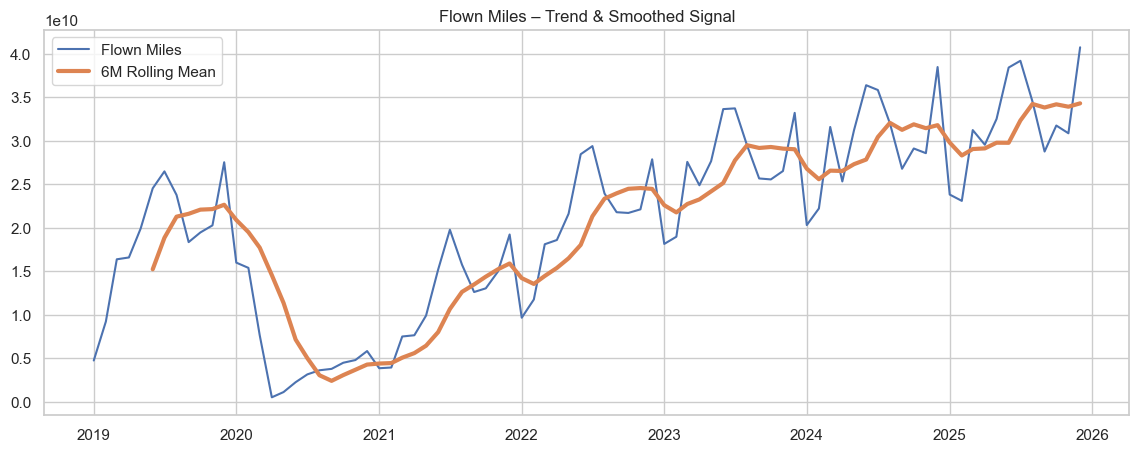

In [32]:
# Target over time (trend + seasonality)
plt.figure(figsize=(14,5))
plt.plot(df['month'], df['flown miles'], label='Flown Miles')
plt.plot(df['month'], df['flown miles rolling mean 6'], label='6M Rolling Mean', linewidth=3)
plt.title('Flown Miles – Trend & Smoothed Signal')
plt.legend()
plt.show()


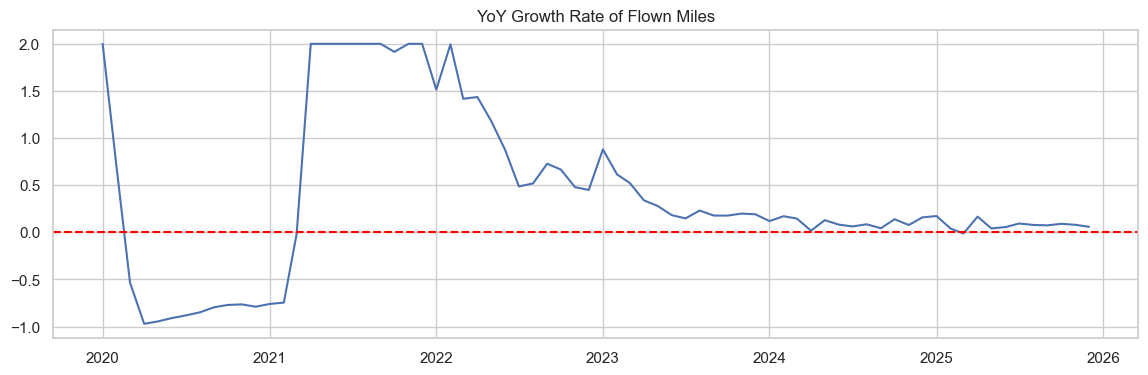

In [ ]:
#YoY growth rate over time
plt.figure(figsize=(14,4))
plt.plot(df['month'], df['flown miles yoy growth'])
plt.axhline(0, color='red', linestyle='--')
plt.title('YoY Growth Rate of Flown Miles')
plt.show()

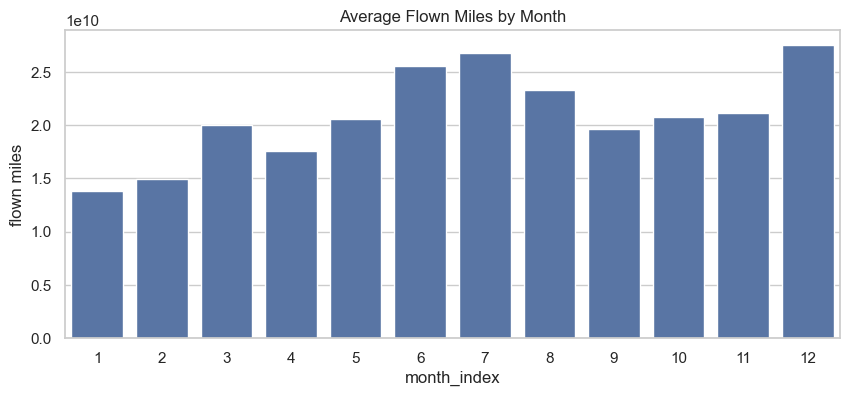

In [ ]:
#Average flown miles by month
seasonality = (df.groupby('month_index')['flown miles'].mean().reset_index())
plt.figure(figsize=(10,4))
sns.barplot(x='month_index', y='flown miles', data=seasonality)
plt.title('Average Flown Miles by Month')
plt.show()
#most of the flown miles are in the month of june and july, and dec. 

In [ ]:
# Correlation of lags and rolling means with the target variable ---> flown miles
lag_cols = ['flown miles lag_3',
    'flown miles lag_6',
    'flown miles lag_12',
    'flown miles rolling mean 3',
    'flown miles rolling mean 6']
df[lag_cols + ['flown miles']].corr()['flown miles'].sort_values(ascending=False)
#rolling mean 3 has the highest correlation with the target variable suprisingly. ---> this indicates that the short term trend is more important than the long term trend for forecasting flown miles.
#usually we would expect the longer term rolling mean to have a higher correlation, but in this case the 3 month rolling mean is more closely aligned with the target variable
# which suggests that recent trends are more influential in predicting flown miles than longer term trends.

flown miles                   1.000000
flown miles rolling mean 3    0.939355
flown miles rolling mean 6    0.884750
flown miles lag_3             0.758929
flown miles lag_6             0.638677
flown miles lag_12            0.605002
Name: flown miles, dtype: float64

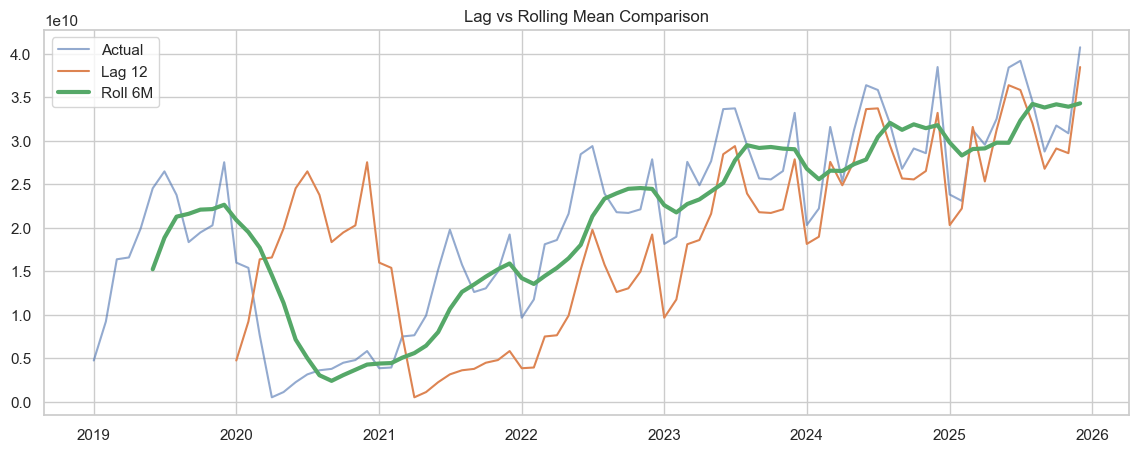

In [ ]:
# Visual comparison of lag and rolling mean features with the target variable
plt.figure(figsize=(14,5))
plt.plot(df['month'], df['flown miles'], label='Actual', alpha=0.6)
plt.plot(df['month'], df['flown miles lag_12'], label='Lag 12')
plt.plot(df['month'], df['flown miles rolling mean 6'], label='Roll 6M', linewidth=3)
plt.legend()
plt.title('Lag vs Rolling Mean Comparison')
plt.show()


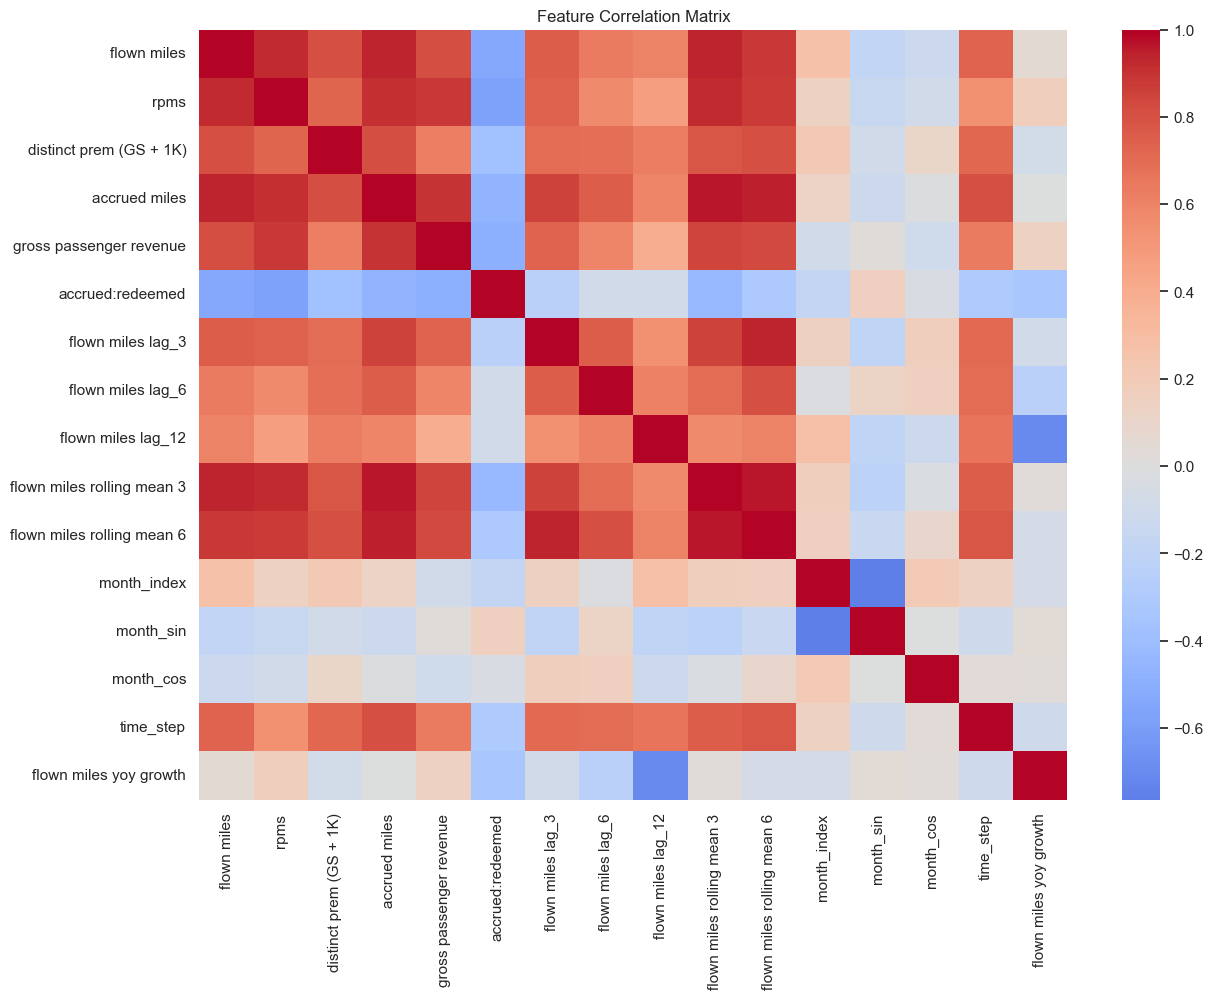

In [ ]:
# Correlation matrix of all features to understand relationships and multicollinearity
numeric_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(14,10))
sns.heatmap(
    df[numeric_cols].corr(),
    cmap='coolwarm',
    center=0
)
plt.title('Feature Correlation Matrix')
plt.show()
# the correlation matrix shows that the accrued:redeemed miles ratio has a strong positive correlation with flown miles, which makes sense as higher flown miles would typically lead to more miles being accrued and redeemed.
# the month index and its cyclic transformations (month_sin and month_cos) also show some correlation with flown miles, indicating that seasonality is an important factor in the data.
# we can drop the lag features if we want to simplify the model, as they are less correlated with the target variable compared to the rolling mean features.

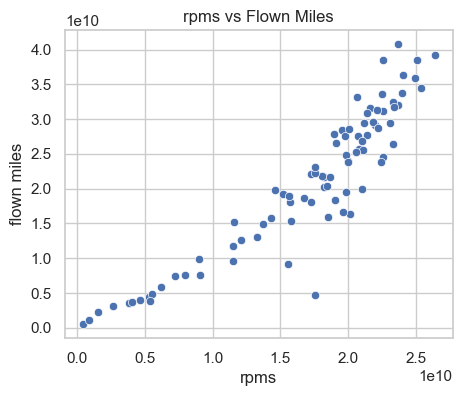

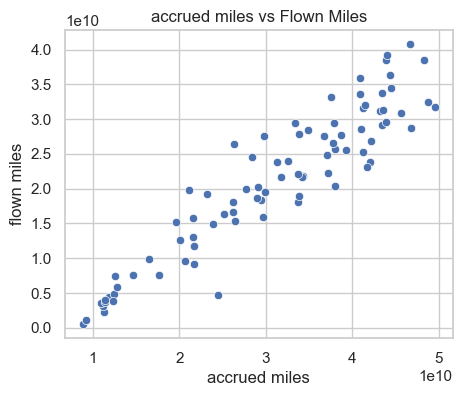

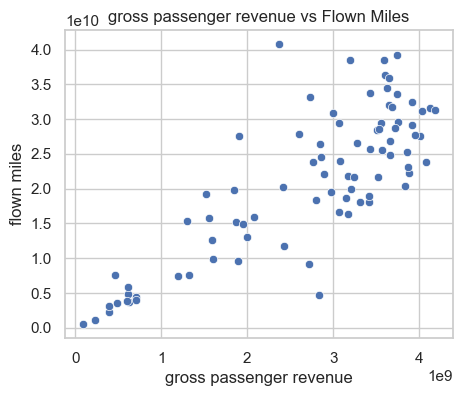

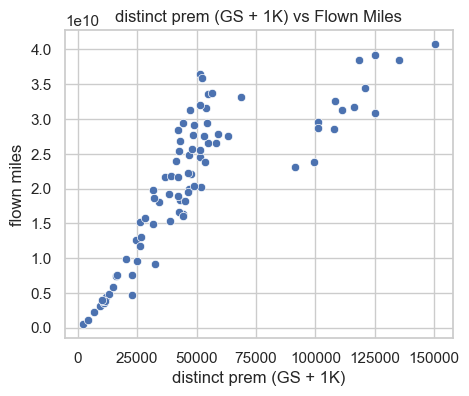

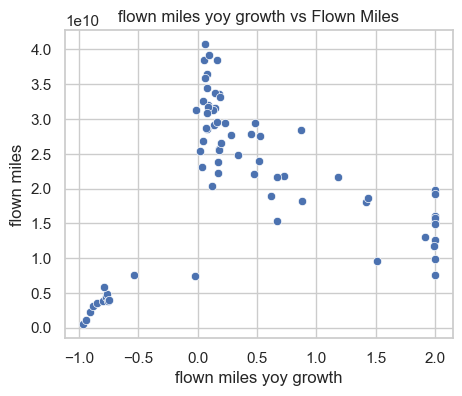

In [ ]:
# Scatter plots of key features vs target variable to visualize relationships
key_features = [
    'rpms',
    'accrued miles',
    'gross passenger revenue',
    'distinct prem (GS + 1K)',
    'flown miles yoy growth'
]

for col in key_features:
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=df[col], y=df['flown miles'])
    plt.title(f'{col} vs Flown Miles')
    plt.show()

# the scatter plots show that there are some positive relationships between the key features and flown miles, particularly with accrued miles and gross passenger revenue, which is expected as they are likely to be directly influenced by the number of miles flown.
# the relationship with rpms is less clear, which may indicate that rpms is not as strong of a predictor for flown miles compared to the other features.
# the distinct premium customers also show a positive relationship, which makes sense as more flown miles would typically lead to more premium customers.


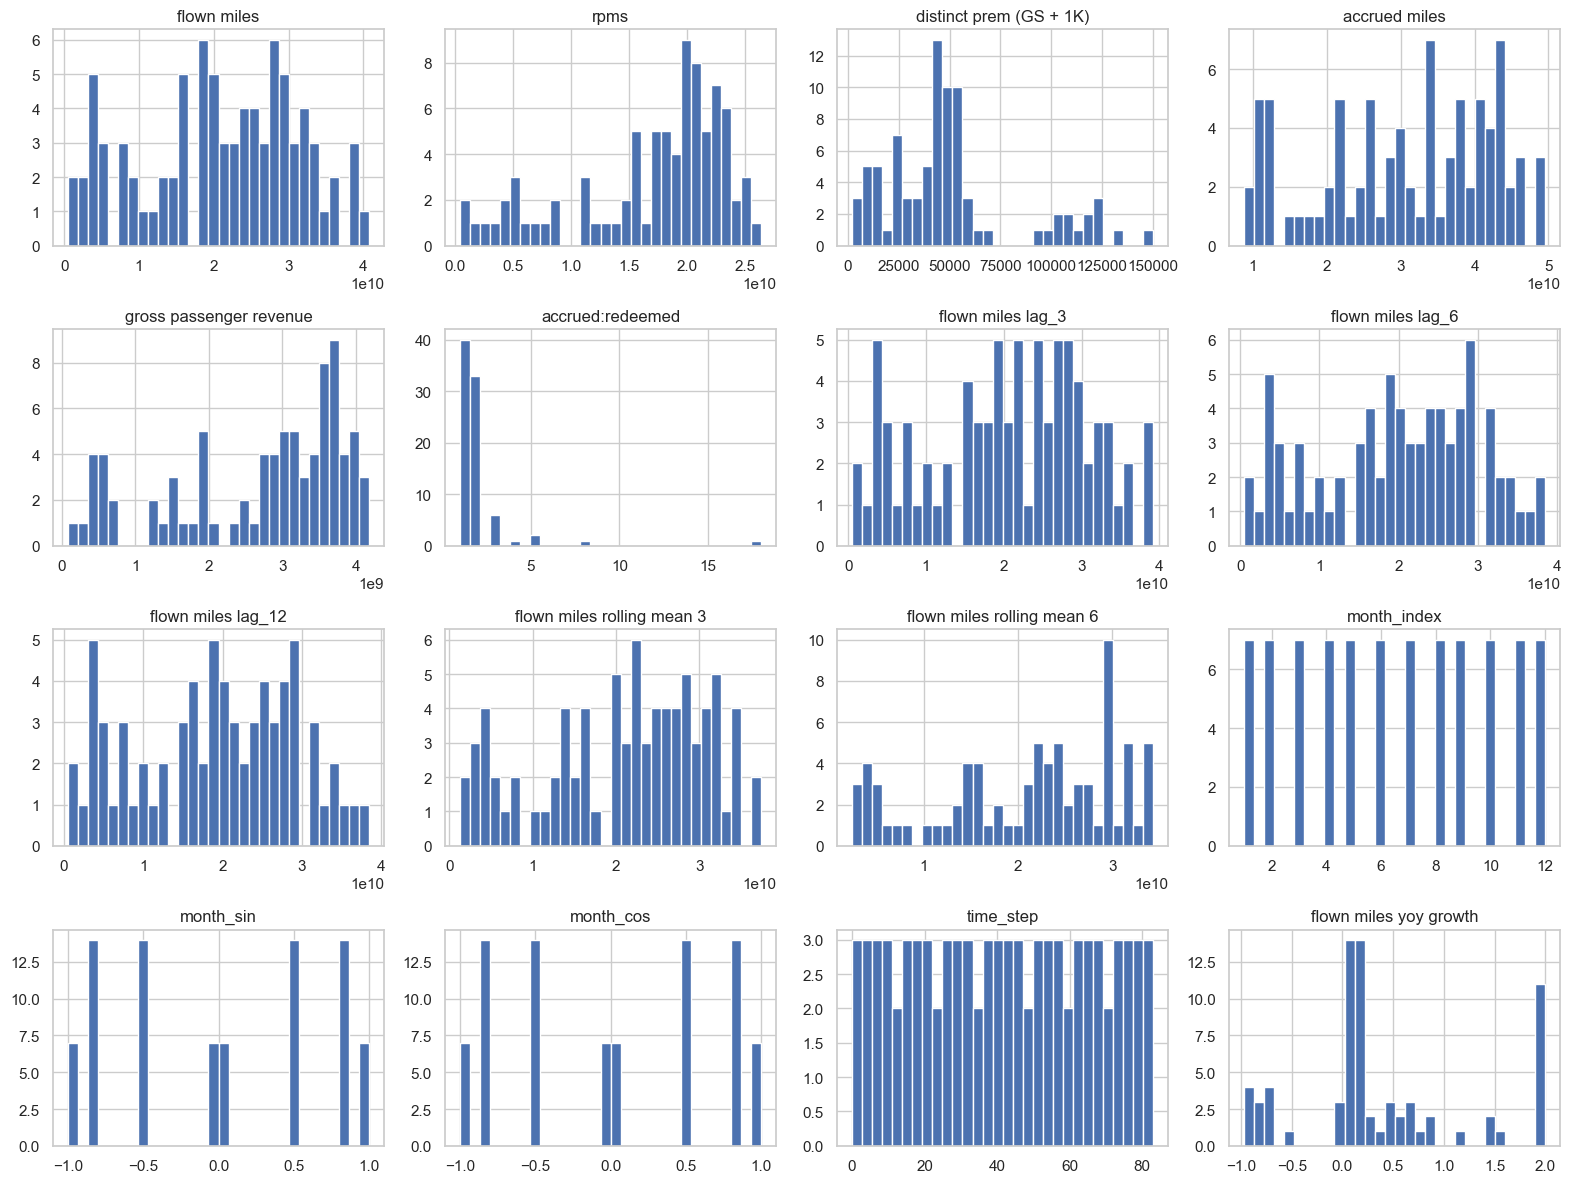

In [ ]:
# Distribution of key features to check for skewness and outliers
df[numeric_cols].hist(bins=30, figsize=(16,12))
plt.tight_layout()
plt.show()
# the histograms show that some features like gross passenger revenue and accrued miles are right skewed, which is common for financial and count data. 
#  This suggests that we may want to consider log transformations or other techniques to handle skewness if we were to build a predictive model.

In [40]:
# ensure no future leakage
assert df['flown miles lag_12'].isna().sum() >= 12
assert df['flown miles rolling mean 6'].isna().sum() >= 5
